# MAUP - Raster

Let's investigate how the modifiable areal unit problem manifests in raster analysis as well as to experiment with aggregation of raster data.

In [1]:
inLibraries = list('repr','rgdal','spdep','rgeos','RColorBrewer','classInt','raster')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Read Observed Measurements

In this practice, let's look at some pollution data collected for New York City (https://catalog.data.gov/dataset/nyccas-air-pollution-rasters).  I basically downloaded this data and simply converted it to .tiff format to make it easier to use on jupyterhub.  The only other modification I had to make to some the files was to set the CRS properly in cases in which it was missing. Five files for the December 2013-December 2014 period represent estimates of NO (nitric oxide), PM (fine particular matter), BC (black carbon), NO2 (carbon dioxide) collected over the year and 03 (ozone) estimated for summer. We're not going to use all of these rasters, but they are referenced here in case you'd like to experiment with them.  

The ones we'll work with primarily here are the black carbon and nitric oxide rasters (rasterFiles3 and 4). Let's consider black carbon the dependent variable and carbon dioxide a predictor variable.

class       : RasterLayer 
dimensions  : 155, 157, 24335  (nrow, ncol, ncell)
resolution  : 984, 984  (x, y)
extent      : 913257.3, 1067745, 120000.1, 272520.1  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=lcc +lat_1=41.03333333333333 +lat_2=40.66666666666666 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +datum=NAD83 +units=us-ft +no_defs +ellps=GRS80 +towgs84=0,0,0 
data source : /dsa/shared/data/geospatial/DS8612/nypollution/aa6_no300m.tif 
names       : aa6_no300m 
values      : 6.06716, 56.61191  (min, max)


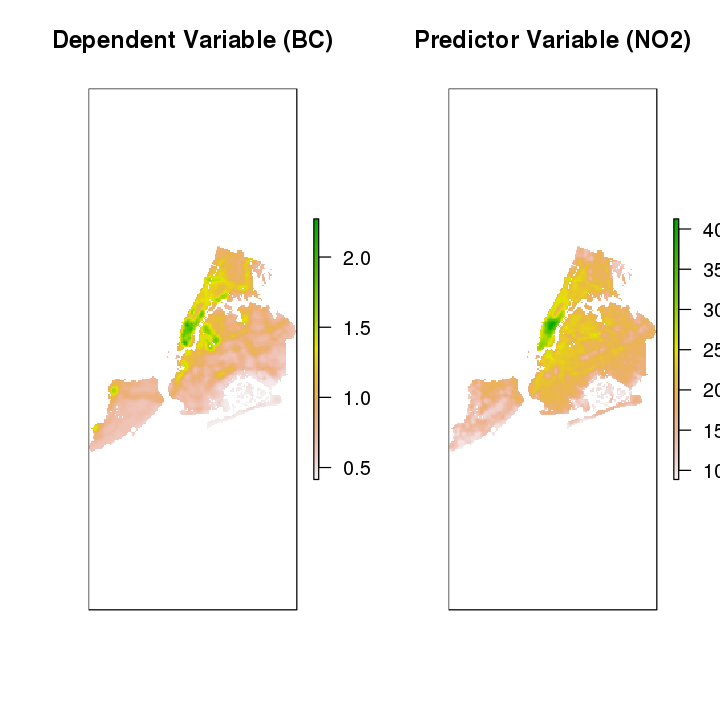

In [2]:
# Read in a raster file
rasterFile1 <- raster ('/dsa/data/geospatial/DS8612/nypollution/aa6_no300m.tif')

# Read in a raster file
rasterFile2 <- raster ('/dsa/data/geospatial/DS8612/nypollution/aa6_pm300m.tif')

# Read in a raster file
rasterFile3 <- raster ('/dsa/data/geospatial/DS8612/nypollution/aa6_bc300m.tif')

# Read in a raster file
rasterFile4 <- raster ('/dsa/data/geospatial/DS8612/nypollution/aa6_no2300m.tif')

# Read in a raster file
rasterFile5 <- raster ('/dsa/data/geospatial/DS8612/nypollution/s6_o3300m.tif')

# print raster info
rasterFile1

# Map raster data
par(mfrow = c(1,2))
plot(rasterFile3, main = "Dependent Variable (BC)", axes = FALSE)
plot(rasterFile4, main = "Predictor Variable (NO2)", axes = FALSE)

## Model A - Original Raster Data

The current spatial resolution of the rasters is 300m x 300m. However, the CRS is in feet, so convert 300 meters to feet if you want the cellsize that corresponds with the raster layers = 984'... or you could simply use the res() function (raster library) to query the spatial resolution of the raster.  Conduct a linear regression to estimate black carbon given observations of carbon dioxide. Retrieve the regression residuals. Note that the predictor is significant and the R2 suggests it accounts for a lot of variation in the data.

In [3]:
#get spatial resolution of raster
res(rasterFile3)

#linear regression based on raster data
modelA <- lm(rasterFile3[] ~ rasterFile4[])

#save model residuals
modelAresiduals <- as.data.frame(residuals(modelA))
modelAresiduals$id <- row.names(modelAresiduals)
colnames(modelAresiduals) <- c("resid", "id")

#report regression
summary(modelA)

[1] 984 984


Call:
lm(formula = rasterFile3[] ~ rasterFile4[])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37627 -0.14470 -0.02178  0.11275  0.86549 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.0063857  0.0086613  -0.737    0.461    
rasterFile4[]  0.0477881  0.0004583 104.282   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1863 on 8758 degrees of freedom
  (15575 observations deleted due to missingness)
Multiple R-squared:  0.5539,	Adjusted R-squared:  0.5539 
F-statistic: 1.087e+04 on 1 and 8758 DF,  p-value: < 2.2e-16


## Evaluate Spatial Autocorrelation

There are some tools in the raster library to test for spatial autocorrelation. However, those tools are not as strong as those in the spdep library. As such, let's apply the cell2nb() function (spdep library) to generate neighborhoods for a raster equivalent in row/column dimensions to those which we are analyzing. Then, create a spdep neighborhood list setting the zero.policy arguement to TRUE which allows the list to be generated even though some cells may have no neighbors. Note that number of cells in the raster data are the same as the number of neighborhoods created...which is a good sign!

In [6]:
#get raster parameters
numcells <- ncell(rasterFile3)
numcols <- ncol(rasterFile3)
numrows <- nrow(rasterFile3)


In [8]:
#apply the 'cell2nb' function
OrigRas.nb <- cell2nb(numrows, numcols, type = "rook", torus = FALSE)

OrigRas.nb[1:5]

[[1]]
[1]   2 156

[[2]]
[1]   1   3 157

[[3]]
[1]   2   4 158

[[4]]
[1]   3   5 159

[[5]]
[1]   4   6 160

In [11]:
#create a nb list
OrigRas.listb <- nb2listw(OrigRas.nb, style = "B", zero.policy = TRUE)

OrigRas.listb$weights[1:5]

[[1]]
[1] 1 1

[[2]]
[1] 1 1 1

[[3]]
[1] 1 1 1

[[4]]
[1] 1 1 1

[[5]]
[1] 1 1 1

In [9]:
#number of cells
length(OrigRas.nb)
numcells

[1] 24335

[1] 24335

### Link Cell Values with Modeled Residuals

Next, retrieve the cell values from the raster dataset to be analyzed. Create a dataframe that contains that contains one row for each raster cell that attributes the cells with their value as well as their row name (as an id value). Link the residuals modeled for each cell with the proper row in the datasframe using the merge() function. Create a copy of the raster to used for storing results that will be obtained later on. Sort the merged file using order() to maintain the proper sequence of values.

In [16]:
#get the values of the raster cells
cellList <- values(rasterFile3)

cellList[1:10]

[1] NA NA NA NA NA NA NA NA NA NA

In [18]:
N <- length(cellList) 

N

[1] 24335

In [19]:
#set up a dataframe to track raster cells
celldf <- data.frame(cellvalue = cellList)
celldf$id <- row.names(celldf)
celldf$id2 <- row.names(celldf)

head(celldf)

cellvalue,id,id2
NA,1,1
NA,2,2
NA,3,3
NA,4,4
NA,5,5
NA,6,6


In [20]:
head(modelAresiduals)

,resid,id
98,0.2000135,98
99,0.1725873,99
255,0.1851161,255
256,0.1803003,256
257,0.1355811,257
258,0.1481843,258


In [22]:
cs <- merge(celldf, modelAresiduals, 
                by.x = "id", 
                by.y = "id", 
                all.x = TRUE, 
                sort = TRUE)

head(cs)

id,cellvalue,id2,resid
1,NA,1,NA
10,NA,10,NA
100,NA,100,NA
1000,NA,1000,NA
10000,0.8897577,10000,-0.1776616
10001,0.8959289,10001,-0.1965198


In [24]:
#set up raster to store results later
OrigRas.var <- raster(rasterFile3)
numcells <- ncell(OrigRas.var)
OrigRas.var[] <- 1:numcells

OrigRas.var[][1:5]

[1] 1 2 3 4 5

In [25]:
#sort, reorder output of merge
celldf <- cs[order(cs$id), ] 
head(celldf, n = 4)

id,cellvalue,id2,resid
1,NA,1,NA
10,NA,10,NA
100,NA,100,NA
1000,NA,1000,NA


### Test for Spatial Autocorrelation

Given that the raster data have been rendered in a dataframe at this point, the moran.test() function (spdep library) can be applied to the residuals associated with each cell. Again, setting zero.policy=TRUE allows the test to proceed given cells may not have neighbors. Also, the na.action=na.exclude argument allows the test to proceed even if NA values are present. Failure to set these arguments will cause the test to fail.

First, let's apply the global Moran test.  Note that the output shows a lot of cells were omitted from analysis. This is due to many cells having NA values or having no neighbors...take a look at the figure of the study data that were output earlier. The Moran test indicates that the likelihood of spatial autocorrelation is definately significant in this case...something that presents a problem for the interpretation of our linear regression results!

In [26]:
#apply Global Moran test to regression residuals
var1 <- celldf$resid

moran.test(var1, OrigRas.listb, 
               zero.policy = TRUE, 
               na.action = na.exclude)


	Moran I test under randomisation

data:  var1  
weights: OrigRas.listb 
omitted: 1, 2, 3, 4, 15, 26, 37, 48, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 137, 147, 148, 149, 150, 159, 170, 181, 192, 203, 214, 225, 226, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 314, 321, 322, 323, 324, 325, 328, 336, 337, 348, 359, 370, 381, 392, 403, 406, 407, 408, 409, 410, 4

#### Local Test for Spatial Autocorrelation

Now, let's apply the local Moran test for spatial autocorrelation on the modeled residuals. After the test is applied, the p-values are extracted from the results and then stored in a new raster so that we can visualize the distribution of the significant values.

In [27]:
#apply local Moran test to regression residuals
OrigRas.lmo <- localmoran(celldf$resid, OrigRas.listb, 
                                      zero.policy = TRUE, 
                                      na.action = na.exclude,
                                      alternative = "greater", 
                                      p.adjust.method = "none", 
                                      mlvar = TRUE, 
                                      spChk = NULL)

#save pvalues
celldf$pvalue <- OrigRas.lmo[, 5]

#store pvalues in new raster
for (i in 1:nrow(celldf)) {
        newid <- as.numeric(celldf$id[i])
        OrigRas.var[newid] <- celldf$pvalue[i]      
    }

In [29]:
celldf[1:10, ]

id,cellvalue,id2,resid,pvalue
1,NA,1,NA,NA
10,NA,10,NA,NA
100,NA,100,NA,NA
1000,NA,1000,NA,NA
10000,0.8897577,10000,-0.17766158,0.8357785
10001,0.8959289,10001,-0.19651979,0.5360608
10002,0.9030268,10002,-0.16375049,0.4489670
10003,0.9051047,10003,-0.14395562,0.4231261
10004,0.9063269,10004,-0.12641028,0.4142176
10005,0.9075915,10005,-0.07606734,0.4971297


### Map the p-values

Classify the Moran p-values into categories and then apply those categories to the raster that was created and produce a map. Note where the test is significant and where it is not...see any patterns/trends in the spatial distribution?

Warning message in classIntervals(celldf$pvalue, numcat, style = "kmeans"):
“var has missing values, omitted in finding classes”

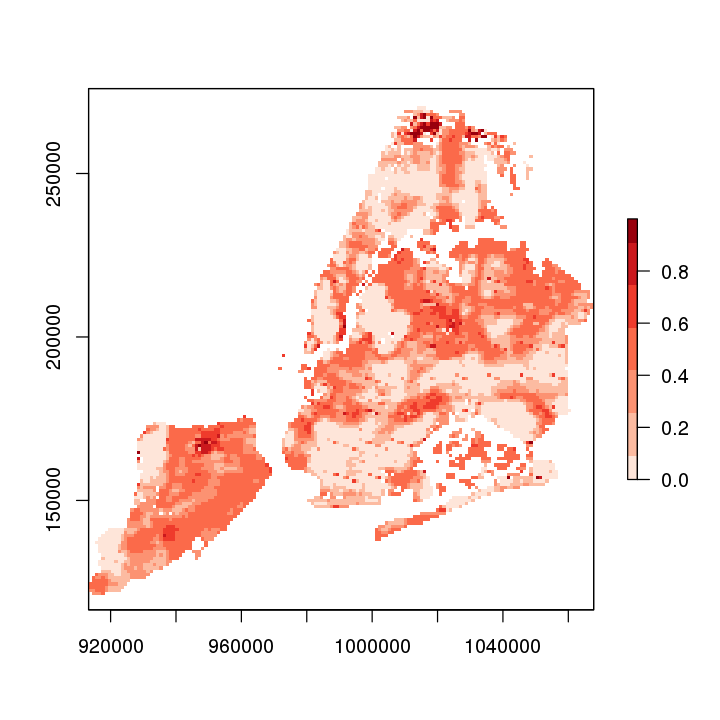

In [30]:
#classify the moran values and assign a color schema
numcat <- 7
cate <- classIntervals(celldf$pvalue, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat, "Reds")


plot(OrigRas.var, col = color.pal)

## Model B - Aggregated Raster Data (2 x 2 function)

Now, aggregate the cells in the two rasters so that there are roughly one half the number of rows and columns than present in the original raster.  This can be done by using the aggregate() function (raster library).  Notice that the spatial resolution of the dataset has changed to 1968'x1968'. Map the two new rasters side-by-side.

In [32]:
#aggregate raster
AggTwoRas3 <- aggregate(rasterFile3, fact = c(2,2), fun = mean, expand = T)
res(AggTwoRas3)

[1] 1968 1968

In [33]:
#aggregate raster
AggTwoRas4 <- aggregate(rasterFile4, fact = c(2,2), fun = mean, expand = T)
res(AggTwoRas4)

[1] 1968 1968

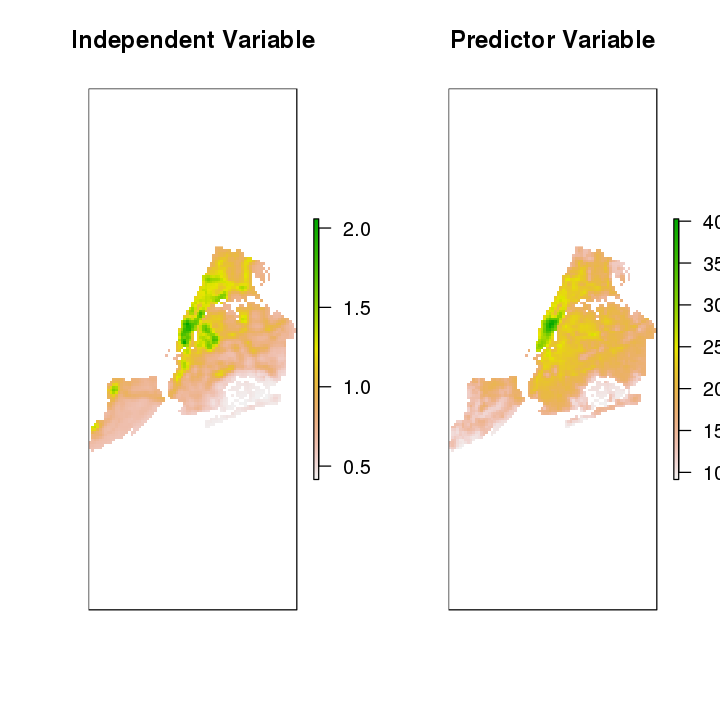

In [34]:
#compute raster to store results
AggTwoRas.var <- raster(AggTwoRas3)
numcells <- ncell(AggTwoRas.var)

AggTwoRas.var[] <- 1:numcells
cellvalues <- as.numeric(lapply(1:numcells, function(x) AggTwoRas.var[x]))

#plot rasters
par(mfrow = c(1,2))
plot(AggTwoRas3, main = "Independent Variable", axes = FALSE)
plot(AggTwoRas4, main = "Predictor Variable", axes = FALSE)

### Model B Regression

Conduct a linear regression to estimate black carbon given observations of carbon dioxide. Retrieve the regression residuals. Note that the modeled results appear to improve a bit over those obtained in Model A.

In [35]:
#linear regression
modelB <- lm(AggTwoRas3[] ~ AggTwoRas4[])

#save residuals
modelBresiduals <- as.data.frame(residuals(modelB))
modelBresiduals$id <- row.names(modelBresiduals)
colnames(modelBresiduals)<- c("resid","id")

#summarize model
summary(modelB)


Call:
lm(formula = AggTwoRas3[] ~ AggTwoRas4[])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36655 -0.14070 -0.02112  0.11158  0.84177 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.0073012  0.0155554  -0.469    0.639    
AggTwoRas4[]  0.0479702  0.0008355  57.417   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1816 on 2432 degrees of freedom
  (3728 observations deleted due to missingness)
Multiple R-squared:  0.5755,	Adjusted R-squared:  0.5753 
F-statistic:  3297 on 1 and 2432 DF,  p-value: < 2.2e-16


### Compute Cell Neighborhoods

In [36]:
#get raster properties
numcells <- ncell(AggTwoRas3)
numcols <- ncol(AggTwoRas3)
numrows <- nrow(AggTwoRas3)

#apply the 'cell2nb' function
AggTwoRas.nb <- cell2nb(numrows, numcols, type="rook", torus=FALSE)

#compute nb list
AggTwoRas.listb <- nb2listw(AggTwoRas.nb,style="B",zero.policy=TRUE)

#number of cells
length(AggTwoRas.nb)

[1] 6162

### Link Cell Values with Residuals

In [37]:
#get the values of the cells   
cellList <- values(AggTwoRas3)
N<- length(cellList)

#create dataframe and merge w/ model residuals
celldf <- data.frame(cellvalue=cellList)
celldf$id <- row.names(celldf)
celldf$id2 <- row.names(celldf)
cs <- merge(celldf,modelBresiduals,by.x="id",by.y="id",all.x=TRUE,sort=TRUE)

#sort, reorder output of merge
celldf <- cs[order(cs$id),] 

### Global Test for Spatial Autocorrelation

Note that the global Moran test results are very similar to those obtained in Model A.

In [38]:
#apply Moran test to residuals
var1 <- celldf$resid
moran.test(var1, AggTwoRas.listb,zero.policy=TRUE,na.action=na.exclude)


	Moran I test under randomisation

data:  var1  
weights: AggTwoRas.listb 
omitted: 1, 2, 3, 14, 16, 17, 18, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 91, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 180, 190, 191, 192, 193, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 2

### Conduct Local Moran Test

In [39]:
#apply local moran test to residuals
AggTwoRas.lmo <- localmoran(celldf$resid, AggTwoRas.listb, zero.policy = TRUE, na.action = na.exclude,
                    alternative = "greater", p.adjust.method = "none", mlvar = TRUE, spChk = NULL)

#save pvalue
celldf$pvalue <- AggTwoRas.lmo[, 5]

#save pvalue to new raster
for (i in 1:nrow(celldf)) {
        newid <- as.numeric(celldf$id[i])
        AggTwoRas.var[newid] <- celldf$pvalue[i]      
    }

### Map the Local Moran p-values

Is the spatial distribution of Moran p-values similiar or different from those in Model A?

Warning message in classIntervals(celldf$pvalue, numcat, style = "kmeans"):
“var has missing values, omitted in finding classes”

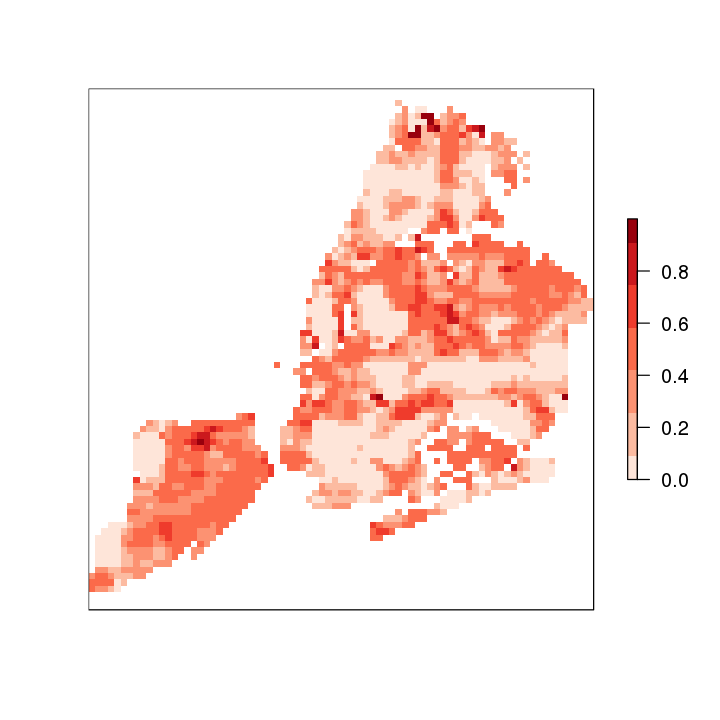

In [40]:
#classify the predicted data values and assign a color schema
numcat <- 7
cate <- classIntervals(celldf$pvalue, numcat, style="kmeans")
color.pal <- brewer.pal(numcat,"Reds")

#plot raster
plot(AggTwoRas.var,col=color.pal,axes=FALSE)

## Model C - Aggregated Raster Data (3 x 3 function)

Now, aggregate the cells in the raster so that there are roughly one third the number of rows and columns than present in the original raster.  This can be done by using the aggregate() function (raster library).  Notice that the spatial resolution of the dataset has changed to 2952'x2952'.

[1] 2952 2952

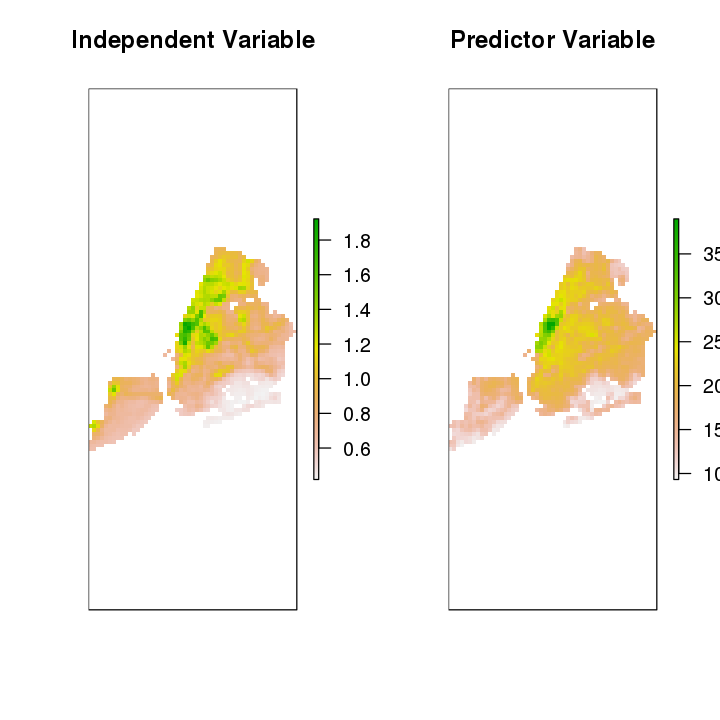

In [41]:
#aggregate raster
AggThreeRas3 <- aggregate(rasterFile3, fact=c(3,3), fun=mean, expand=T)
res(AggThreeRas3)

#aggregate raster
AggThreeRas4 <- aggregate(rasterFile4, fact=c(3,3), fun=mean, expand=T)

#create raster to use later
AggThreeRas.var <- raster(AggThreeRas3)
numcells <- ncell(AggThreeRas.var)
AggThreeRas.var[] <- 1:numcells
cellvalues <- as.numeric(lapply(1:numcells,function(x) AggThreeRas.var[x]))

#plot rasters
par(mfrow=c(1,2))
plot(AggThreeRas3,main="Independent Variable",axes=FALSE)
plot(AggThreeRas4,main="Predictor Variable",axes=FALSE)

### Model C regression

Conduct a linear regression to estimate black carbon given estimates of carbon dioxide. Retrieve the regression residuals. Note how the regression results differ from those obtained in Model A and B.

In [42]:
#linear regression
modelC <- lm(AggThreeRas3[] ~ AggThreeRas4[])

#save residuals
modelCresiduals <- as.data.frame(residuals(modelC))
modelCresiduals$id <- row.names(modelCresiduals)
colnames(modelCresiduals)<- c("resid","id")

#summarize regression
summary(modelC)


Call:
lm(formula = AggThreeRas3[] ~ AggThreeRas4[])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3439 -0.1354 -0.0200  0.1084  0.8162 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -0.015193   0.021556  -0.705    0.481    
AggThreeRas4[]  0.048395   0.001171  41.340   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1763 on 1163 degrees of freedom
  (1591 observations deleted due to missingness)
Multiple R-squared:  0.5951,	Adjusted R-squared:  0.5947 
F-statistic:  1709 on 1 and 1163 DF,  p-value: < 2.2e-16


### Generate Neighborhoods for Cells

In [43]:
#get raster properties
numcells <- ncell(AggThreeRas3)
numcols <- ncol(AggThreeRas3)
numrows <- nrow(AggThreeRas3)

#apply the 'cell2nb' function
AggThreeRas.nb <- cell2nb(numrows, numcols, type="rook", torus=FALSE)

#calculate nb list
AggThreeRas.listb <- nb2listw(AggThreeRas.nb,style="B",zero.policy=TRUE)

#get output size
length(AggThreeRas.nb)

[1] 2756

### Link the Cell Values and Model Residuals

In [44]:
#get the values of the cells   
cellList <- values(AggThreeRas3)
N<- length(cellList)

#create dataframe and merge with residuals
celldf <- data.frame(cellvalue=cellList)
celldf$id <- row.names(celldf)
celldf$id2 <- row.names(celldf)
cs <- merge(celldf,modelCresiduals,by.x="id",by.y="id",all.x=TRUE,sort=TRUE)

#sort, reorder output of merge
celldf <- cs[order(cs$id),] 

### Apply Global Moran Test

Note how the test results differ from those obtained in Models A and B.

In [45]:
#apply Moran test
var1 <- celldf$resid
moran.test(var1, AggThreeRas.listb,zero.policy=TRUE,na.action=na.exclude)


	Moran I test under randomisation

data:  var1  
weights: AggThreeRas.listb 
omitted: 1, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 47, 58, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 102, 113, 114, 125, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 158, 169, 180, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 224, 225, 236, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 280, 291, 302, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 335, 336, 347, 358, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 3

### Apply Local Moran Test

In [46]:
#apply local moran test
AggThreeRas.lmo <- localmoran(celldf$resid, AggThreeRas.listb, zero.policy=TRUE,na.action=na.exclude,
alternative = "greater", p.adjust.method="none", mlvar=TRUE,
spChk=NULL)

#save pvalues
celldf$pvalue <- AggThreeRas.lmo[,5]

#store pvalues in raster
for (i in 1:nrow(celldf)) {
    newid <- as.numeric(celldf$id[i])
    AggThreeRas.var[newid] <- celldf$pvalue[i]      
    }

### Map the Local Moran p-values

Note how the results are different/similar to those obtained in Models A and B.

Warning message in classIntervals(celldf$pvalue, numcat, style = "kmeans"):
“var has missing values, omitted in finding classes”

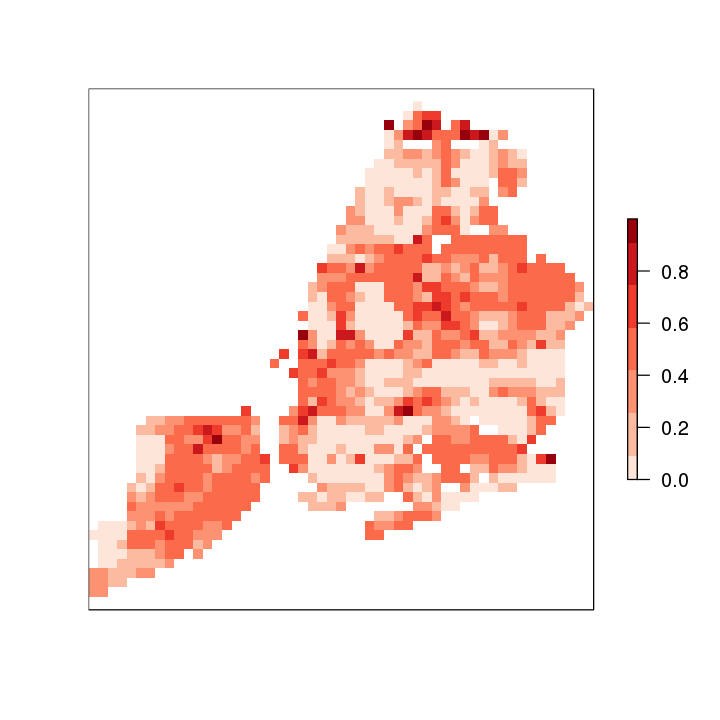

In [47]:
#classify the predicted data values and assign a color schema
numcat <- 7
cate <- classIntervals(celldf$pvalue, numcat, style="kmeans")
color.pal <- brewer.pal(numcat,"Reds")

#plot raster
plot(AggThreeRas.var,col=color.pal,axes=FALSE)

### MAUP Comparison

Plot the three areal representation of the study site and their relative Moran p-values. Note where and to what extent similarities and differences occur.  Which areal representation would you choose?

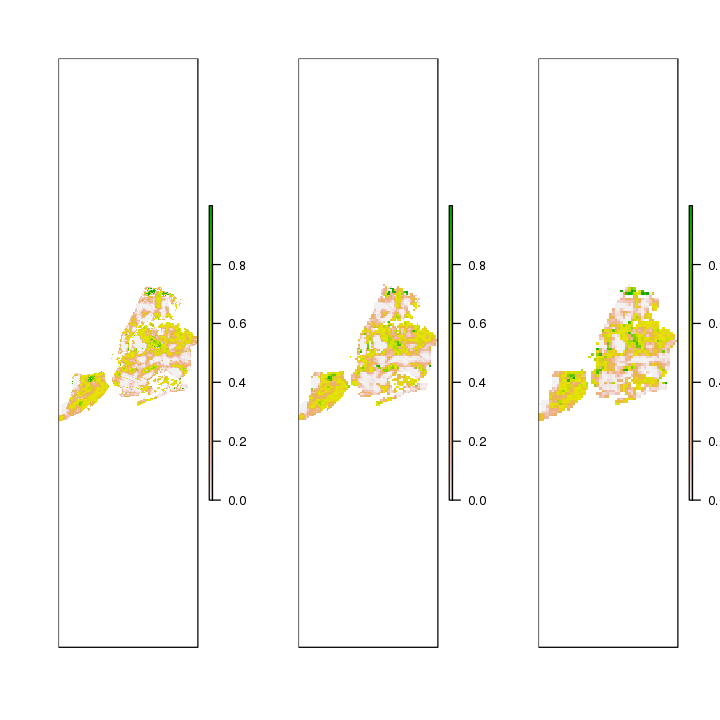

In [48]:
#plot maps side-by-side
par(mfrow = c(1,3))
plot(OrigRas.var, axes = FALSE)
plot(AggTwoRas.var, axes = FALSE)
plot(AggThreeRas.var, axes = FALSE)